This notebook finds and plots angles between each pair of subspaces identified by dPCA for both RNN and EEG (UMI-PMI, UMI-decision, PMI-decision).

In [ ]:
!pip install dpca

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

In [ ]:
%cd /content/gdrive/My Drive/dpca_code_V2/
from pumi import *
import dpca as dp
from fit_scaling import *
import matplotlib.pyplot as plt
import scipy.stats as stats
import math

In [ ]:
dataset = 'rnn'
num_unit = 60
ndim = 2
if dataset is 'rnn':
  %cd /content/gdrive/My Drive/data/2Bonly_60units_2tr_circ
  num_sub = 10
elif dataset is 'eeg':
  %cd /content/gdrive/My Drive/data/2b_cont_eegmat
  num_sub = 42

#arrays to store angles between encoders
angle_up = np.zeros((num_sub))
angle_ud = np.zeros((num_sub))
angle_pd = np.zeros((num_sub))

for subject_id in range(num_sub):

  if dataset is 'rnn':
    ori_wholeTrial = load_data_rnn(subject_id+1, num_unit = num_unit, tw = None, dataset = dataset)
    dec_wholeTrial =  load_data_rnn(subject_id+1, num_unit = num_unit, tw = None, decision = True, dataset = dataset)
   
    tw = 2 #use second delay timepoint to construct dPC space
    umi_tmp = center(ori_wholeTrial[:,2,:][:,np.newaxis,:])
    pmi_tmp = center(ori_wholeTrial[:,5,:][:,np.newaxis,:])
    dec_tmp = dec_wholeTrial[:,:,3,:][:,:,np.newaxis,:] #decision timestep (stimulus presentation)
    dec_tmp = dec_tmp - np.vstack(np.vstack(dec_tmp)).mean(0)

  elif dataset is 'eeg':
    ori_tmp = load_data(subject_id+1, tw = None, dataset = dataset) 
    umi_tmp = center(ori_tmp[:,70:140,:]) #-1400-0ms relative to n+1 onset
    pmi_tmp = center(ori_tmp[:,247:318,:])#2150-3550ms
    dec_tmp = load_data(subject_id+1, tw = None, dataset = dataset, decision = True)
    dec_tmp = dec_tmp[:,:,150:175,:] #200-700ms
    dec_tmp = dec_tmp - np.vstack(np.vstack(dec_tmp)).mean(0)

  umi_model = dp.dPCA(umi_tmp, n_dim = ndim, old_version=True)
  pmi_model = dp.dPCA(pmi_tmp, n_dim = ndim, old_version=True)
  dec_model = dp.dPCA(dec_tmp, n_dim = ndim, old_version=False, decision = True)

  #dPCA encoders
  e_UMI = umi_model.encoder
  e_PMI = pmi_model.encoder
  e_DEC = dec_model.encoder
  
  #calculate subspace angles
  angle_up[subject_id] = np.rad2deg(math.acos(np.abs(np.dot(e_UMI[:,0], e_PMI[:,0]))*np.abs(np.dot(e_UMI[:,1], e_PMI[:,1]))))
  angle_ud[subject_id] = np.rad2deg(math.acos(np.abs(np.dot(e_UMI[:,0], e_DEC[:,0]))*np.abs(np.dot(e_UMI[:,1], e_DEC[:,1]))))
  angle_pd[subject_id] = np.rad2deg(math.acos(np.abs(np.dot(e_PMI[:,0], e_DEC[:,0]))*np.abs(np.dot(e_PMI[:,1], e_DEC[:,1]))))

  print(subject_id)

In [ ]:
#RNN
print(f'PMI-decision angle: mean = {angle_pd.mean()}, std = {angle_pd.std()}')
print(f'UMI-decision angle: mean = {angle_ud.mean()}, std = {angle_ud.std()}')
print(f'UMI-PMI angle: mean = {angle_up.mean()}, std = {angle_up.std()}')

PMI-decision angle: mean 35.25019589342902, std = 13.247104672625413
UMI-decision angle: mean 81.25670626932406, std = 2.063154890936973
UMI-PMI angle: mean 84.12780284823532, std = 3.9131564705009243


In [ ]:
#EEG
print(f'PMI-decision angle: mean = {angle_pd.mean()}, std = {angle_pd.std()}')
print(f'UMI-decision angle: mean = {angle_ud.mean()}, std = {angle_ud.std()}')
print(f'UMI-PMI angle: mean = {angle_up.mean()}, std = {angle_up.std()}')

PMI-decision angle: mean 82.73511842802623, std = 8.742718584840006
UMI-decision angle: mean 81.8032813987312, std = 6.689757946216698
UMI-PMI angle: mean 76.86634635902341, std = 12.328085900421655


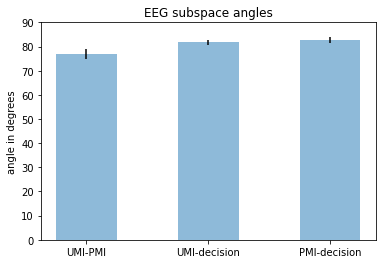

In [ ]:
mean_angle = [angle_up.mean(), angle_ud.mean(), angle_pd.mean()]
error_angle = [stats.sem(angle_up), stats.sem(angle_ud), stats.sem(angle_pd)]

#plot bar graph
objects = ('UMI-PMI','UMI-decision','PMI-decision')
fig, ax = plt.subplots()
y_pos = np.arange(len(objects))
ax.bar(y_pos, mean_angle, yerr=error_angle, width = 0.5,align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('angle in degrees')
plt.ylim([0,90])
plt.title('EEG subspace angles')

plt.show()